In [17]:
# ==========================================================
# 1. Imports
# ==========================================================
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
import matplotlib.pyplot as plt

# ==========================================================
# 2. Load Data
# ==========================================================
df = pd.read_csv("main.csv")
df.columns = df.columns.str.strip()
df["Date"] = pd.to_datetime(df["Date"])
df["Location"] = df["Location"].str.strip().str.upper()

# ==========================================================
# 3. Filtering
# ==========================================================
sel = (
    (df["Date"] > pd.to_datetime('2022-01-01')) &
    (df["Lactation Number"] > 0) &
    (df["Lactation Number"] < 5) &
    (df["Location"].isin(["MILKING AREA A", "MILKING AREA B"])) &
    (df["Day Production"] > 15) &
    (df["Lactation Days"] > 1.0) &
    (df["Lactation Days"] < 300.0)
)

df = df[sel].copy()
print("Filtered dataset shape:", df.shape)

# ==========================================================
# 4. Feature Engineering
# ==========================================================

# ---- 3-day distributed heat load
df = df.sort_values(["Animal Life No.", "Date"])

df["THI_3d"] = df.groupby("Animal Life No.")["THI_max"].transform(
    lambda x: x.rolling(3, min_periods=1).mean()
)

# ---- Proper centering BEFORE quadratic term
THI_mean = df["THI_3d"].mean()

df["THI_c"] = df["THI_3d"] - THI_mean
df["THI_c_sq"] = df["THI_c"]**2

# Lactation
df["LactDays_c"] = df["Lactation Days"] - df["Lactation Days"].mean()

# Seasonality
df["doy"] = df["Date"].dt.dayofyear
df["doy_sin"] = np.sin(2 * np.pi * df["doy"] / 365.25)
df["doy_cos"] = np.cos(2 * np.pi * df["doy"] / 365.25)

# ==========================================================
# 5. OLS with Clustered SE
# ==========================================================

formula = """
Q('Day Production') ~ 
THI_c + THI_c_sq +
LactDays_c +
Q('Lactation Number') +
C(Location) +
doy_sin + doy_cos
"""

model = smf.ols(formula, data=df).fit(
    cov_type="cluster",
    cov_kwds={"groups": df["Animal Life No."]}
)

print(model.summary())

print("\nDurbin-Watson:", sm.stats.durbin_watson(model.resid))

# ==========================================================
# 6. Correct Turning Point
# ==========================================================

b1 = model.params["THI_c"]
b2 = model.params["THI_c_sq"]

peak_centered = -b1 / (2 * b2)
peak_real_THI = peak_centered + THI_mean

print(f"\nEstimated THI peak production at ≈ {round(peak_real_THI,2)}")

# ==========================================================
# 7. Counterfactual Simulation Function
# ==========================================================

def simulate_counterfactual(cap_value):

    df_cf = df.copy()

    # Cap original THI
    df_cf["THI_3d"] = np.minimum(df_cf["THI_3d"], cap_value)

    # Recreate centered variables consistently
    df_cf["THI_c"] = df_cf["THI_3d"] - THI_mean
    df_cf["THI_c_sq"] = df_cf["THI_c"]**2

    # Predictions
    df["Pred_Observed"] = model.predict(df)
    df_cf["Pred_NoHS"] = model.predict(df_cf)

    daily_obs = (
        df.groupby(["Date", "Location"])["Pred_Observed"]
        .mean()
        .reset_index()
    )

    daily_cf = (
        df_cf.groupby(["Date", "Location"])["Pred_NoHS"]
        .mean()
        .reset_index()
    )

    daily = daily_obs.merge(daily_cf, on=["Date", "Location"])
    daily["Loss_kg"] = daily["Pred_NoHS"] - daily["Pred_Observed"]
    daily["Percent_Loss"] = daily["Loss_kg"] / daily["Pred_NoHS"] * 100

    return daily

# ==========================================================
# 8. Main Scenario
# ==========================================================

daily = simulate_counterfactual(68)

# ==========================================================
# 9. Bootstrap CI
# ==========================================================

rng = np.random.default_rng(42)
N_BOOT = 2000
boot_results = []

for loc in daily["Location"].unique():

    area_df = daily[daily["Location"] == loc]
    losses = area_df["Loss_kg"].values
    n = len(losses)

    boot_means = np.empty(N_BOOT)
    boot_totals = np.empty(N_BOOT)

    for i in range(N_BOOT):
        idx = rng.integers(0, n, size=n)
        sample = losses[idx]
        boot_means[i] = np.mean(sample)
        boot_totals[i] = np.sum(sample)

    ci_mean = np.percentile(boot_means, [2.5, 97.5])
    ci_total = np.percentile(boot_totals, [2.5, 97.5])

    boot_results.append({
        "Location": loc,
        "Mean Loss (kg/day)": np.mean(losses),
        "Mean % Loss": area_df["Percent_Loss"].mean(),
        "CI_mean_lower": ci_mean[0],
        "CI_mean_upper": ci_mean[1],
        "Total Loss (kg)": np.sum(losses),
        "CI_total_lower": ci_total[0],
        "CI_total_upper": ci_total[1]
    })

boot_ci_df = pd.DataFrame(boot_results)

print("\nBOOTSTRAP RESULTS\n")
print(boot_ci_df)

# ==========================================================
# 10. Economic Loss (€)
# ==========================================================

MILK_PRICE = 0.42
boot_ci_df["Total Loss (€)"] = boot_ci_df["Total Loss (kg)"] * MILK_PRICE

print("\nECONOMIC IMPACT (€)\n")
print(boot_ci_df[["Location", "Total Loss (€)"]])

# ==========================================================
# 11. Sensitivity Analysis
# ==========================================================

caps = [66, 68, 70]
sensitivity = []

for cap in caps:
    daily_tmp = simulate_counterfactual(cap)
    for loc in daily_tmp["Location"].unique():
        total_loss = daily_tmp[daily_tmp["Location"] == loc]["Loss_kg"].sum()
        sensitivity.append({
            "Cap": cap,
            "Location": loc,
            "Total Loss (kg)": total_loss
        })

sensitivity_df = pd.DataFrame(sensitivity)

print("\nSENSITIVITY ANALYSIS\n")
print(sensitivity_df)

Filtered dataset shape: (58028, 17)
                             OLS Regression Results                            
Dep. Variable:     Q('Day Production')   R-squared:                       0.365
Model:                             OLS   Adj. R-squared:                  0.365
Method:                  Least Squares   F-statistic:                     102.6
Date:                 Mon, 16 Feb 2026   Prob (F-statistic):           1.38e-49
Time:                         22:15:12   Log-Likelihood:            -1.9715e+05
No. Observations:                58028   AIC:                         3.943e+05
Df Residuals:                    58020   BIC:                         3.944e+05
Df Model:                            7                                         
Covariance Type:               cluster                                         
                                    coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------


COUNTERFACTUAL HEAT STRESS ANALYSIS — SUMMARY

             Area  Mean MY (Observed)  Mean MY (No HS)  Mean Loss (kg/day)  \
0  MILKING AREA A               39.29            39.60                0.31   
1  MILKING AREA B               37.94            38.25                0.31   

   Mean % Loss  Total Loss per animal (kg)  N days  
0         0.80                      438.28    1406  
1         0.81                      438.00    1406  

BOOTSTRAP CONFIDENCE INTERVALS

         Location  Mean Loss (kg/day)  Mean % Loss 95% CI (Mean)  \
0  MILKING AREA A            0.311720     0.802883   [0.3, 0.33]   
1  MILKING AREA B            0.311519     0.812928   [0.3, 0.33]   

   Total Loss (kg) 95% CI (Total)  Total Loss (€)  
0       438.278857     [415, 462]       184.07712  
1       437.995072     [417, 460]       183.95793  


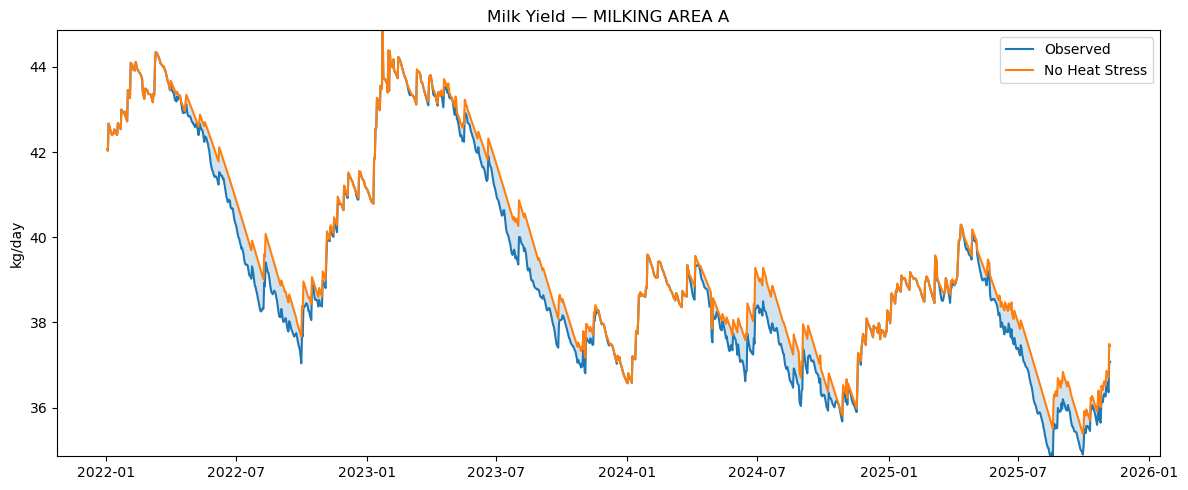

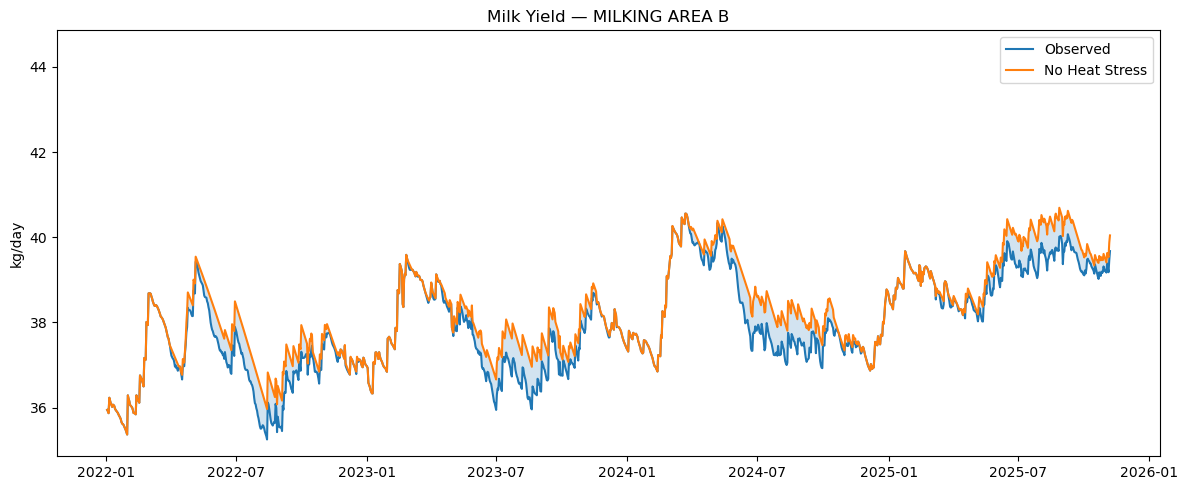

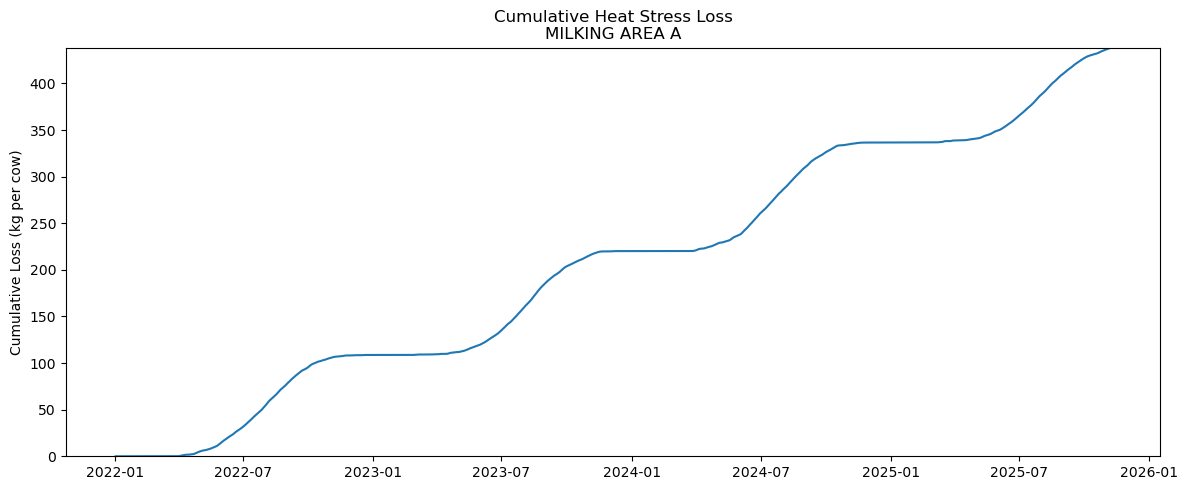

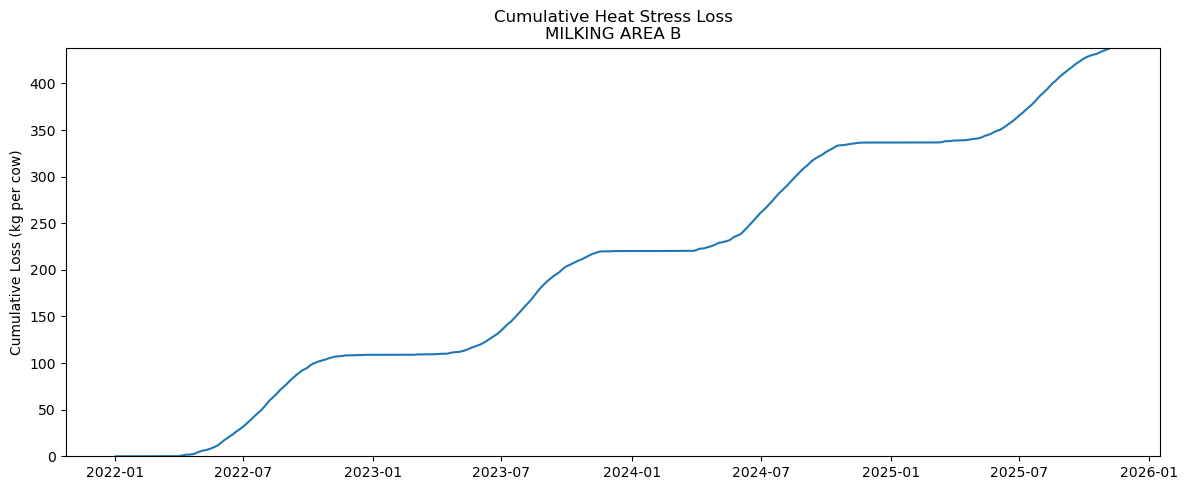

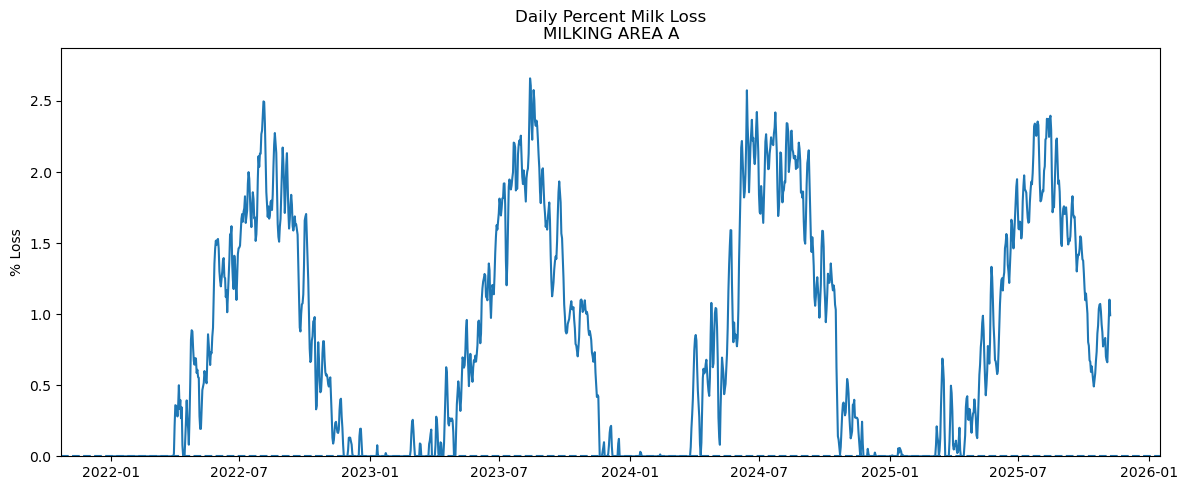

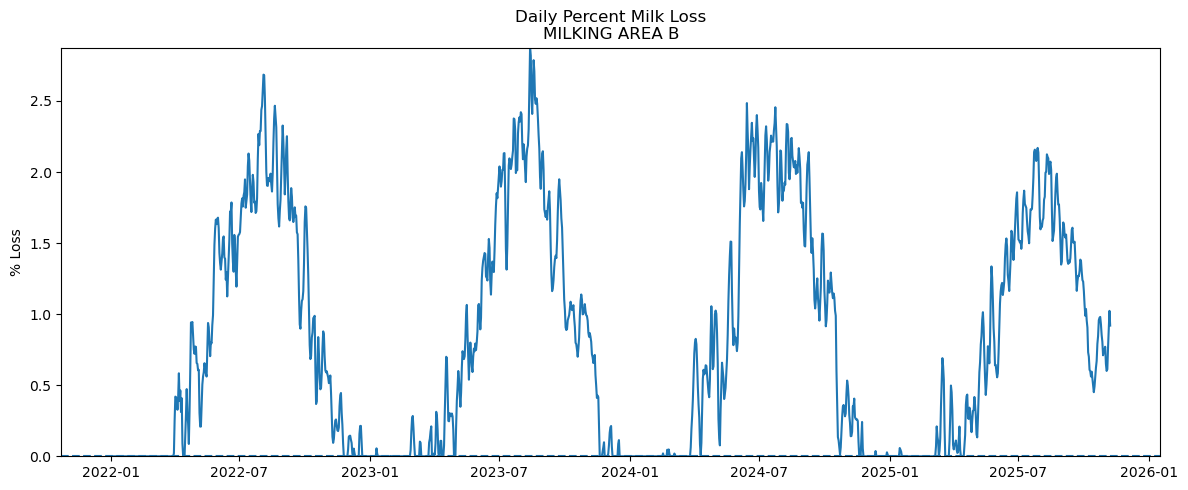

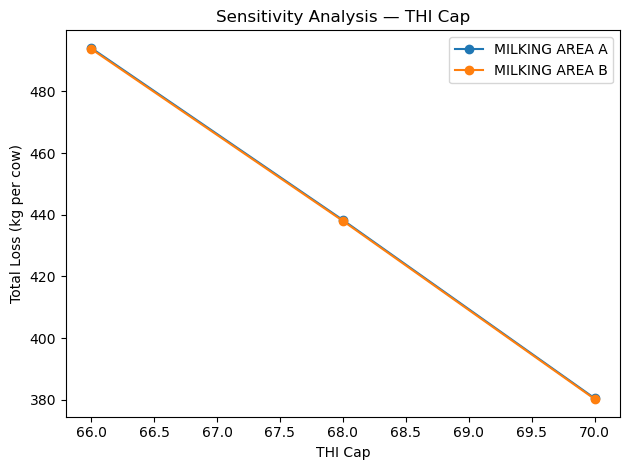

In [19]:
# Summary Table (Observed vs Counterfactual)
summary_rows = []

for loc in daily["Location"].unique():

    area_df = daily[daily["Location"] == loc]

    summary_rows.append({
        "Area": loc,
        "Mean MY (Observed)": round(area_df["Pred_Observed"].mean(), 2),
        "Mean MY (No HS)": round(area_df["Pred_NoHS"].mean(), 2),
        "Mean Loss (kg/day)": round(area_df["Loss_kg"].mean(), 2),
        "Mean % Loss": round(area_df["Percent_Loss"].mean(), 2),
        "Total Loss per animal (kg)": round(area_df["Loss_kg"].sum(), 2),
        "N days": area_df.shape[0]
    })

summary_table = pd.DataFrame(summary_rows)

print("\nCOUNTERFACTUAL HEAT STRESS ANALYSIS — SUMMARY\n")
print(summary_table)


# Bootstrap Table
boot_display = boot_ci_df.copy()

boot_display["95% CI (Mean)"] = (
    "[" +
    boot_display["CI_mean_lower"].round(2).astype(str) +
    ", " +
    boot_display["CI_mean_upper"].round(2).astype(str) +
    "]"
)

boot_display["95% CI (Total)"] = (
    "[" +
    boot_display["CI_total_lower"].round(0).astype(int).astype(str) +
    ", " +
    boot_display["CI_total_upper"].round(0).astype(int).astype(str) +
    "]"
)

boot_display = boot_display[[
    "Location",
    "Mean Loss (kg/day)",
    "Mean % Loss",
    "95% CI (Mean)",
    "Total Loss (kg)",
    "95% CI (Total)",
    "Total Loss (€)"
]]

print("\nBOOTSTRAP CONFIDENCE INTERVALS\n")
print(boot_display)


# Common y-axis limits
y_min_milk = min(daily["Pred_Observed"].min(), daily["Pred_NoHS"].min())
y_max_milk = max(daily["Pred_Observed"].max(), daily["Pred_NoHS"].max())

daily_sorted = daily.sort_values(["Location", "Date"]).copy()
daily_sorted["Cumulative_Loss"] = daily_sorted.groupby("Location")["Loss_kg"].cumsum()
y_min_cum = daily_sorted["Cumulative_Loss"].min()
y_max_cum = daily_sorted["Cumulative_Loss"].max()

y_min_pct = daily["Percent_Loss"].min()
y_max_pct = daily["Percent_Loss"].max()


# Observed vs Counterfactual Plot
for loc in daily["Location"].unique():

    area_df = daily[daily["Location"] == loc]

    plt.figure(figsize=(12,5))
    plt.plot(area_df["Date"], area_df["Pred_Observed"], label="Observed")
    plt.plot(area_df["Date"], area_df["Pred_NoHS"], label="No Heat Stress")
    plt.fill_between(area_df["Date"],
                     area_df["Pred_Observed"],
                     area_df["Pred_NoHS"],
                     alpha=0.2)
    plt.ylim(y_min_milk, y_max_milk)
    plt.title(f"Milk Yield — {loc}")
    plt.ylabel("kg/day")
    plt.legend()
    plt.tight_layout()
    plt.show()


# Cumulative Loss Plot
for loc in daily_sorted["Location"].unique():

    area_df = daily_sorted[daily_sorted["Location"] == loc]

    plt.figure(figsize=(12,5))
    plt.plot(area_df["Date"], area_df["Cumulative_Loss"])
    plt.ylim(y_min_cum, y_max_cum)
    plt.title(f"Cumulative Heat Stress Loss\n{loc}")
    plt.ylabel("Cumulative Loss (kg per cow)")
    plt.tight_layout()
    plt.show()


# Daily Percent Loss Plot
for loc in daily["Location"].unique():

    area_df = daily[daily["Location"] == loc]

    plt.figure(figsize=(12,5))
    plt.plot(area_df["Date"], area_df["Percent_Loss"])
    plt.axhline(0, linestyle="--")
    plt.ylim(y_min_pct, y_max_pct)
    plt.title(f"Daily Percent Milk Loss\n{loc}")
    plt.ylabel("% Loss")
    plt.tight_layout()
    plt.show()
    

# Sensitivity Plot (THI Caps)
for loc in sensitivity_df["Location"].unique():
    tmp = sensitivity_df[sensitivity_df["Location"] == loc]
    plt.plot(tmp["Cap"], tmp["Total Loss (kg)"], marker="o", label=loc)

plt.xlabel("THI Cap")
plt.ylabel("Total Loss (kg per cow)")
plt.title("Sensitivity Analysis — THI Cap")
plt.legend()
plt.tight_layout()
plt.show()